## Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in the gravitational-wave class; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course, careful with overfitting here).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.
- Plot ROC curves
- **Important** Don't use `snr` as feature in your classifer (that's the answer...)

In [ ]:
# LECTURE 20: The goal here is to machine-learn the LIGO detectability: can we predict if a gravitational-wave source will be detected?
# with discriminant classification

In [2]:
import numpy as np
from matplotlib import pyplot as pltc
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import parallel_backend

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

/home/alessandrangeloni/VirtualEnv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Main keys: ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
chi1x: shape=(20000000,), dtype=float64
chi1y: shape=(20000000,), dtype=float64
chi1z: shape=(20000000,), dtype=float64
chi2x: shape=(20000000,), dtype=float64
chi2y: shape=(20000000,), dtype=float64
chi2z: shape=(20000000,), dtype=float64
dec: shape=(20000000,), dtype=float64
det: shape=(20000000,), dtype=int64
iota: shape=(20000000,), dtype=float64
mtot: shape=(20000000,), dtype=float64
psi: shape=(20000000,), dtype=float64
q: shape=(20000000,), dtype=float64
ra: shape=(20000000,), dtype=float64
snr: shape=(20000000,), dtype=float64
z: shape=(20000000,), dtype=float64
Data loaded with size: 1000000
Are there any Nan?  False
Are there any infinity values?  False
corr_matrix
det      1.000000
q        0.059640
chi1z    0.053523
chi2z    0.016676
chi2x    0.000577
psi      0.000043
chi1y   -0.000322
chi1x   -0.000748
chi2y   -0.001081
dec     -0.001974
iota    -0

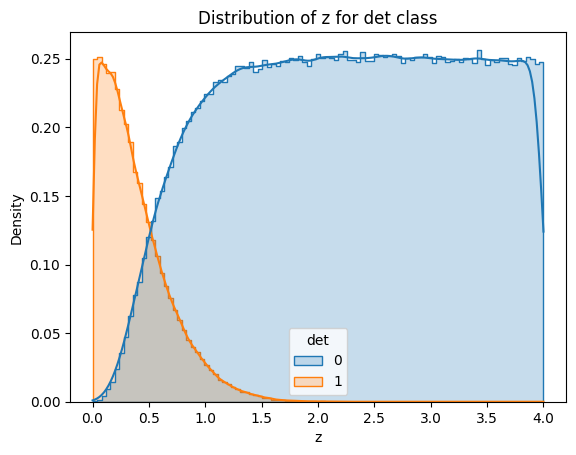

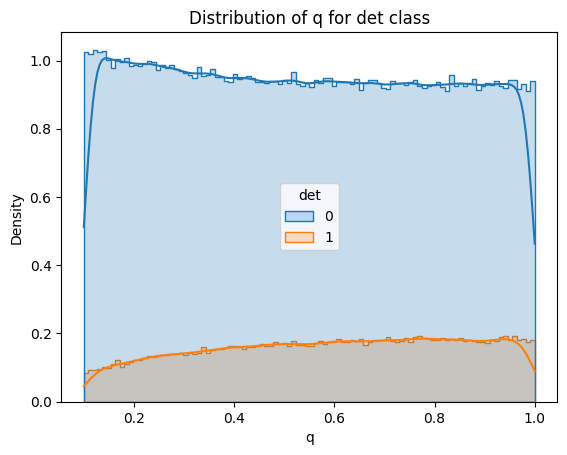

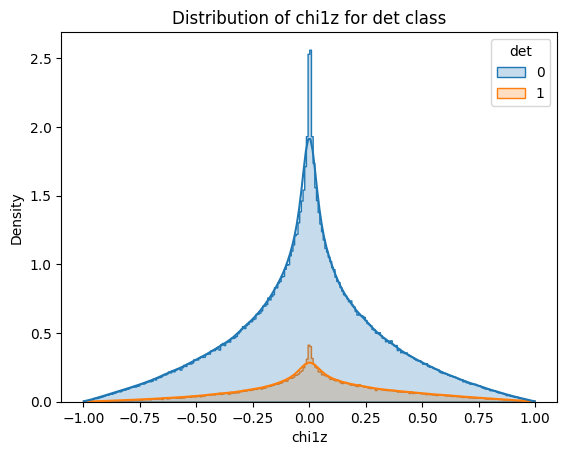

det
0    0.855543
1    0.144457
Name: proportion, dtype: float64


In [3]:
with h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r') as f:
    print("Main keys:", list(f.keys()))
    
    N = 1000000
    chi1x = f['chi1x'][:N]
    chi1y = f['chi1y'][:N]
    chi1z = f['chi1z'][:N]
    chi2x = f['chi2x'][:N]
    chi2y = f['chi2y'][:N]
    chi2z = f['chi2z'][:N]
    dec = f['dec'][:N]
    det = f['det'][:N] # 0 = snr<12 / 1 = snr>12 -> LIGO see/doesn't see a source  
    iota = f['iota'][:N]
    mtot = f['mtot'][:N]
    psi = f['psi'][:N]
    q = f['q'][:N]
    ra = f['ra'][:N]
    snr = f['snr'][:N] # not used as a feature
    z = f['z'][:N]

    for key in f.keys():
        print(f"{key}: shape={f[key].shape}, dtype={f[key].dtype}")
    
    print("Data loaded with size:", N)

data_matrix = np.stack([chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, dec, iota, mtot, psi, q, ra, z], axis = 1)
columns = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']
data = pd.DataFrame(data_matrix, columns=columns)

# NaN/inf control
print("Are there any Nan? ", data.isnull().values.any())
print("Are there any infinity values? ", np.isinf(data.values).any())

# features = data || target = det || snr = answer
x_train, x_test, y_train, y_test = train_test_split(data, det, test_size = 0.2, random_state = 42) 

# EDA — Exploratory Data Analysis: check the dataset balance, identify important or redundant features
corr_matrix = data.assign(det=det) # add the det to the DataFrame
corr_matrix = corr_matrix.corr() # correlation between det and features
print("corr_matrix")
print(corr_matrix['det'].sort_values(ascending=False))


data['det'] = det  # add det to DataFrame

feat = ['z', 'q', 'chi1z']
for f in feat: 
    sns.histplot(data=data, x=f'{f}', hue='det', kde=True, element="step", stat="density") # x = feature || y = densità
    plt.title(f'Distribution of {f} for det class')
    plt.show()

print(data['det'].value_counts(normalize=True))  # percentage distribution of classes in the target det  
# 0: 85.55% data: gravitational source has been detected -> can train model to predict the detection

100%|██████████| 100/100 [04:35<00:00,  2.75s/it]0:00<?, ?it/s]



Confusion matrix:
 [[168869   2103]
 [  3710  25318]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    170972
           1       0.92      0.87      0.90     29028

    accuracy                           0.97    200000
   macro avg       0.95      0.93      0.94    200000
weighted avg       0.97      0.97      0.97    200000



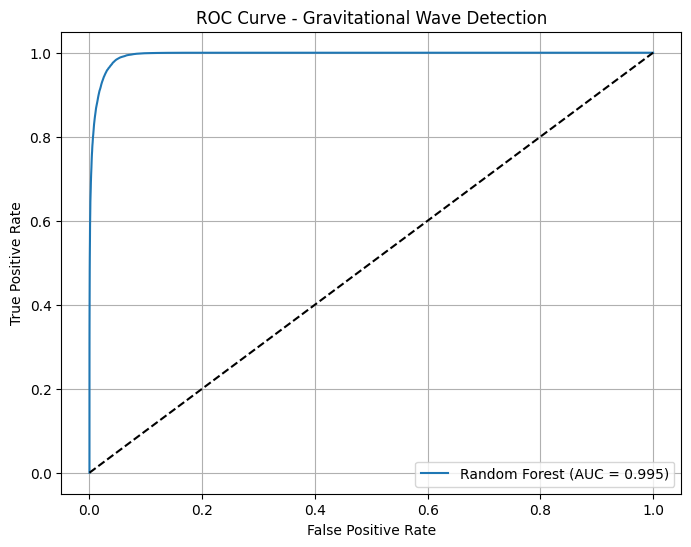

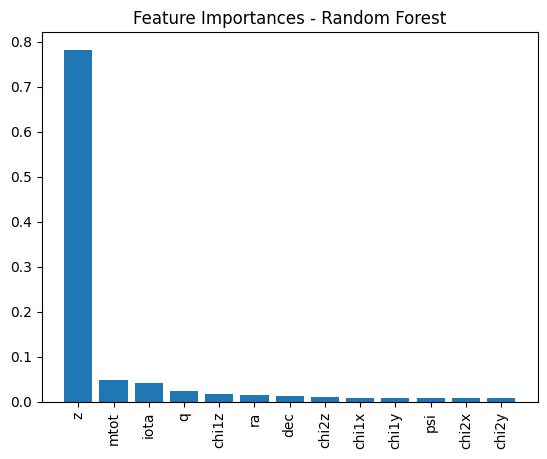


Training Random Forest:   0%|          | 0/100 [04:39<?, ?it/s]

































































































100%|██████████| 100/100 [02:14<00:00,  1.35s/it]



Confusion matrix:
 [[165761   5211]
 [  7170  21858]]

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96    170972
           1       0.81      0.75      0.78     29028

    accuracy                           0.94    200000
   macro avg       0.88      0.86      0.87    200000
weighted avg       0.94      0.94      0.94    200000



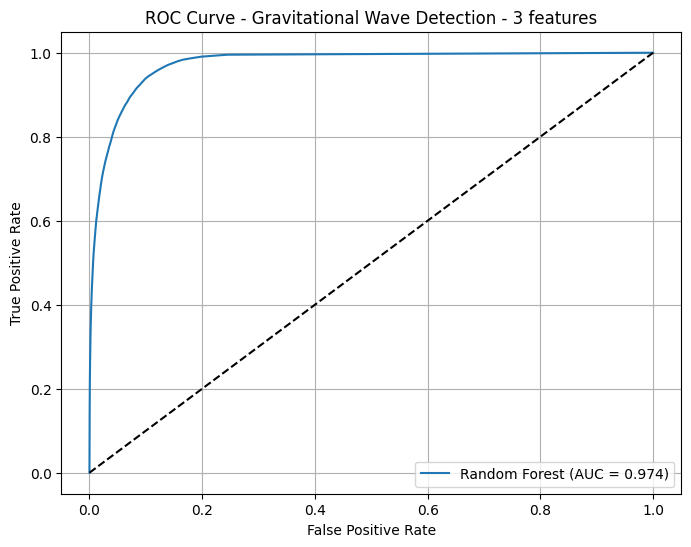

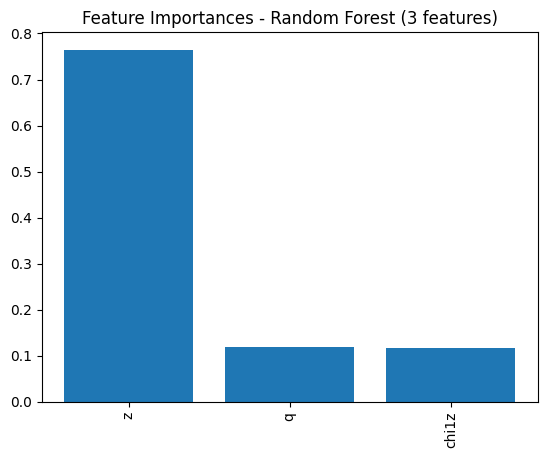

In [4]:
# > RANDOM FOREST: splitting features on which to generate the tree are selected at random from the full set of features

# progress bar
with parallel_backend('loky'):
    with tqdm(total=100) as pbar:
        def update(*args):
            pbar.update()

# class_weight = balanced - as we have 0: 0.855543 and 1: 0.144457
# n_jobs = -1 -> use all the cores of the machine
RFC = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced') 

with tqdm_joblib(tqdm(desc="Training Random Forest", total=100)) as progress_bar:
    RFC.fit(x_train, y_train)
    
y_probs = RFC.predict_proba(x_test)[:, 1]  # probability det=1 (for ROC curve)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

y_pred = RFC.predict(x_test)
print()
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')  # performance of a random classifier, i.e. a model that cannot distinguish classes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gravitational Wave Detection')
plt.legend()
plt.grid()
plt.show()

# Importance of features for det prediction
importances = RFC.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), [columns[i] for i in sorted_indices], rotation=90)
plt.show()

# >> only 3 features: z, q, chi1z
selected_features = ['z', 'q', 'chi1z']  
x_train_sub = x_train[selected_features]
x_test_sub = x_test[selected_features]

RFC3 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
with tqdm_joblib(tqdm(desc="Training Random Forest", total=100)) as progress_bar:
    RFC3.fit(x_train_sub, y_train)

y_probs = RFC3.predict_proba(x_test_sub)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

y_pred = RFC3.predict(x_test_sub)
print()
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gravitational Wave Detection - 3 features')
plt.legend()
plt.grid()
plt.show()

# Feature importance (3 feature model)
importances = RFC3.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sub_columns = selected_features  # ['z', 'q', 'chi1z']

plt.title("Feature Importances - Random Forest (3 features)")
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), [sub_columns[i] for i in sorted_indices], rotation=90)
plt.show()